In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import glob
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report
import scipy

from performer_pytorch import PerformerLM
from utils import *


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.is_available()
world_size = torch.cuda.device_count()

In [36]:
ckpt_dir = "ckpts"

In [37]:
finetune_model_list = ['finetune_shuffledataseedwise_seed'+str(i) for i in [1000, 2000, 3000, 4000, 2021, 2022, 2023]]
#the finetuning runs that came from sample efficiency experiments with fraction data = 1.0:
sampleff_frac1_list = ['finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_1.0_0', 'finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_1.0_1', 'finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_1.0_2']

In [38]:
nog2v_model_list = ['finetune_nog2v_shuffledataseedwise_seed'+str(i) for i in [1000, 2000, 3000, 4000, 0, 5000, 10000, 2021, 2022, 2023]]

In [39]:
no_pretraining_model_list = ['finetune_nopretraining_shuffledataseedwise_seed'+str(i) for i in [1000, 2000, 3000, 4000, 0, 5000, 10000, 2021, 2022, 2023]]

In [9]:
class SCDataset(Dataset):
    def __init__(self, data, label, use_continuous):
        super().__init__()
        self.data = data
        self.label = label
        self.use_continuous = use_continuous

    def __getitem__(self, index):
        #rand_start = random.randint(0, self.data.shape[0]-1)
        full_seq = self.data[index].toarray()[0]
        full_seq[full_seq > (CLASS - 2)] = CLASS - 2
        full_seq = torch.from_numpy(full_seq).long() #long() converts to int64
        if(not self.use_continuous):
            full_seq = full_seq.long() #long() converts to int64
        full_seq = torch.cat((full_seq, torch.tensor([0]))).to(device) #this is the CLS token ?
        seq_label = self.label[index]
        return full_seq, seq_label

    def __len__(self):
        return self.data.shape[0]

class Identity(torch.nn.Module):
    def __init__(self, dropout = 0., h_dim = 100, out_dim = 10):
        super(Identity, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, (1, 200))
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(in_features=SEQ_LEN, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x):
        x = x[:,None,:,:]
        x = self.conv1(x)
        x = self.act(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [10]:
BATCH_SIZE = 64
CLASS = 7 
USE_CONTINUOUS = False
SIN_EMB_WAVELENGTH = None
DATA_PATH = '/data/rna_rep_learning/scBERT/Zheng68K.h5ad'
G2V_FILE = '/data/rna_rep_learning/scBERT/gene2vec_16906.npy'
device = 'cuda'

In [11]:
data = sc.read_h5ad(DATA_PATH)

label_dict, label = np.unique(np.array(data.obs['celltype']), return_inverse=True)  # Convert strings categorical to integrate categorical, and label_dict[label] can be restored
class_num = np.unique(label, return_counts=True)[1].tolist() 
#class_weight = torch.tensor([(1 - (x / sum(class_num))) ** 2 for x in class_num]) #doesn't get used anywhere
class_weight = torch.tensor([1/x for x in class_num])  #use this simpler weighting
label = torch.from_numpy(label)
data = data.X
SEQ_LEN = data.shape[1] + 1 # num_genes + 1

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2022) #update to hardcode to reduce sources of randomness/isolate performance differences between MODELS
for index_train, index_val in sss.split(data, label):
    data_train, label_train = data[index_train], label[index_train]
    data_val, label_val = data[index_val], label[index_val]
    train_dataset = SCDataset(data_train, label_train, USE_CONTINUOUS)
    val_dataset = SCDataset(data_val, label_val, USE_CONTINUOUS)
print("size of training data: {}".format(len(train_dataset)))
#train_sampler = DistributedSampler(train_dataset, shuffle=True)
#val_sampler = DistributedSampler(val_dataset, shuffle=True)

# attempt to seed dataloader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)

size of training data: 54760


In [12]:
all_model_paths = [glob.glob('ckpts/{}/*/*best.pth'.format(x))[0] for x in finetune_model_list]
all_model_paths += [glob.glob('ckpts/{}/*best.pth'.format(x))[0] for x in sampleff_frac1_list]
#all_model_paths += [glob.glob('ckpts/{}/*/*best.pth'.format(x))[0] for x in nog2v_model_list]
#all_model_paths += [glob.glob('ckpts/{}/*/*best.pth'.format(x))[0] for x in no_pretraining_model_list]

In [79]:
#reweight for class balance
class_weight = torch.tensor([1/x for x in class_num])  #use this simpler weighting
loss_fn = nn.CrossEntropyLoss(weight=class_weight).to(device)

# load model
accs = []
accs_hard = []
f1s = []
f1s_hard = []
experiment = []
for ckpt_path in all_model_paths:
    if 'nog2v' in ckpt_path:
        POS_EMBED_USING = False
        exp = 'no_g2v'
    else:
        POS_EMBED_USING = True
        if 'pretraining' in ckpt_path:
            exp = 'no_pretraining'
        else:
            exp = 'finetune'
    experiment.append(exp)
    print("Loading model: {}".format(ckpt_path))
    print("Experiment: {}".format(exp))
    model = PerformerLM(
        num_tokens = CLASS,
        dim = 200,
        depth = 6,
        max_seq_len = SEQ_LEN,
        heads = 10,
        local_attn_heads = 0,
        g2v_position_emb = POS_EMBED_USING,
        g2v_file = G2V_FILE,
        pred_continuous = USE_CONTINUOUS,
        sin_emb_wavelength = SIN_EMB_WAVELENGTH,
    )
    model = model.to(device)

    # Load checkpoint
    checkpoint = torch.load(ckpt_path, map_location=device)
    consume_prefix_in_state_dict_if_present(checkpoint['model_state_dict'], "module.")
    #print("Loaded finetuned ckpt...")
    model.to_out = Identity(dropout=0., h_dim=128, out_dim=label_dict.shape[0])
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)    
    cur_epoch = checkpoint['epoch']

    # model eval
    model.eval()
    running_loss = 0.0
    predictions = []
    truths = []
    # hard to distinguish cell types: CD8+ cytotoxic T cells and CD8+/CD45RA+ T cells (F1-score = 0.788 versus 0.617, P-value = 9.025 × 10 −5; accuracy = 0.801 versus 0.724, P-value = 2.265 × 10−5)
    predictions_hard = []
    truths_hard = []
    with torch.no_grad():
        for index, (data_v, labels_v) in enumerate(val_loader):
            index += 1
            data_v, labels_v = data_v.to(device), labels_v.to(device)
            logits = model(data_v)
            loss = loss_fn(logits, labels_v)
            running_loss += loss.item()
            softmax = nn.Softmax(dim=-1)
            final_prob = softmax(logits)
            final = final_prob.argmax(dim=-1)
            #final[np.amax(np.array(final_prob.cpu()), axis=-1) < UNASSIGN_THRES] = -1
            predictions.append(final)
            truths.append(labels_v)
            predictions_hard.append(final[(labels_v == np.where(label_dict=='CD8+ Cytotoxic T')[0][0]) | (labels_v == np.where(label_dict=='CD8+/CD45RA+ Naive Cytotoxic')[0][0])])
            truths_hard.append(labels_v[(labels_v == np.where(label_dict=='CD8+ Cytotoxic T')[0][0]) | (labels_v == np.where(label_dict=='CD8+/CD45RA+ Naive Cytotoxic')[0][0])])
        del data_v, labels_v, logits, final_prob, final
        # gather
        predictions = torch.cat(predictions, dim=0)
        predictions_hard = torch.cat(predictions_hard, dim=0).cpu()
        truths = torch.cat(truths, dim=0)
        truths_hard = torch.cat(truths_hard, dim=0).cpu()
        no_drop = predictions != -1
        predictions = np.array((predictions[no_drop]).cpu())
        truths = np.array((truths[no_drop]).cpu())
        cur_acc = accuracy_score(truths, predictions)
        f1 = f1_score(truths, predictions, average='macro')
        val_loss = running_loss / index
        accs.append(cur_acc)
        accs_hard.append(accuracy_score(truths_hard, predictions_hard))
        f1s.append(f1)
        f1s_hard.append(f1_score(truths, predictions, average='macro', labels=[np.where(label_dict=='CD8+ Cytotoxic T')[0][0], np.where(label_dict=='CD8+/CD45RA+ Naive Cytotoxic')[0][0]]))
        print("Val accuracy: {} || Val F1: {}".format(cur_acc, f1))
        print("\n")

Loading model: ckpts/finetune_shuffledataseedwise_seed1000/2023-Sep-06-11:53:39/finetune_shuffledataseedwise_seed1000_best.pth
Experiment: finetune
Val accuracy: 0.7732651570489408 || Val F1: 0.6792136768260693


Loading model: ckpts/finetune_shuffledataseedwise_seed2000/2023-Sep-06-16:20:42/finetune_shuffledataseedwise_seed2000_best.pth
Experiment: finetune
Val accuracy: 0.7716581446311176 || Val F1: 0.672881168001843


Loading model: ckpts/finetune_shuffledataseedwise_seed3000/2023-Sep-06-20:47:39/finetune_shuffledataseedwise_seed3000_best.pth
Experiment: finetune
Val accuracy: 0.7385682980277575 || Val F1: 0.6641635728794179


Loading model: ckpts/finetune_shuffledataseedwise_seed4000/2023-Sep-07-01:14:57/finetune_shuffledataseedwise_seed4000_best.pth
Experiment: finetune
Val accuracy: 0.7738495252008766 || Val F1: 0.6731558172693294


Loading model: ckpts/finetune_shuffledataseedwise_seed2021/2023-Sep-07-05:41:52/finetune_shuffledataseedwise_seed2021_best.pth
Experiment: finetune
V

In [80]:
pd.DataFrame({'experiment':experiment, 'accuracy':accs, 'f1':f1s, 'acc_hard':accs_hard, 'f1_hard':f1s_hard})

,experiment,accuracy,f1,acc_hard,f1_hard
0,finetune,0.773265,0.679214,0.783155,0.789308
1,finetune,0.771658,0.672881,0.779679,0.787832
2,finetune,0.738568,0.664164,0.698529,0.751786
3,finetune,0.773850,0.673156,0.774733,0.788734
4,finetune,0.730972,0.646564,0.682086,0.745264
5,finetune,0.780278,0.679008,0.815374,0.795863
6,finetune,0.767348,0.661498,0.776337,0.784371
7,finetune,0.788824,0.704074,0.813102,0.806227
8,finetune,0.759313,0.673905,0.749733,0.773306
9,finetune,0.780862,0.699019,0.774866,0.794109


In [81]:
pd.DataFrame({'experiment':experiment, 'accuracy':accs, 'f1':f1s, 'acc_hard':accs_hard, 'f1_hard':f1s_hard}).to_csv("outputs/finetuning_n10_shuffledata_final_metrics.csv")

In [40]:
# ran nog2v and nopretrain in separate notebooks so that would be quicker -- collate results
res_ft = pd.read_csv("outputs/finetuning_n10_shuffledata_final_metrics.csv")
res_nog2v = pd.read_csv("outputs/finetuning_nog2v_n10_shuffledata_final_metrics.csv")
res_nopretraining = pd.read_csv("outputs/finetuning_nopretrain_n10_shuffledata_final_metrics.csv")

#concatenate
res = pd.concat([res_ft, res_nog2v, res_nopretraining])
res.drop(columns=['Unnamed: 0'], inplace=True)
res['model'] = finetune_model_list + sampleff_frac1_list + nog2v_model_list + no_pretraining_model_list
res = res.reset_index().drop(columns="index")

In [83]:
res

,experiment,accuracy,f1,acc_hard,f1_hard,model
0,finetune,0.773265,0.679214,0.783155,0.789308,finetune_shuffledataseedwise_seed1000
1,finetune,0.771658,0.672881,0.779679,0.787832,finetune_shuffledataseedwise_seed2000
2,finetune,0.738568,0.664164,0.698529,0.751786,finetune_shuffledataseedwise_seed3000
3,finetune,0.773850,0.673156,0.774733,0.788734,finetune_shuffledataseedwise_seed4000
4,finetune,0.730972,0.646564,0.682086,0.745264,finetune_shuffledataseedwise_seed2021
5,finetune,0.780278,0.679008,0.815374,0.795863,finetune_shuffledataseedwise_seed2022
6,finetune,0.767348,0.661498,0.776337,0.784371,finetune_shuffledataseedwise_seed2023
7,finetune,0.788824,0.704074,0.813102,0.806227,finetune-sampleeff-2023-Aug-31-23:37:02/finetu...
8,finetune,0.759313,0.673905,0.749733,0.773306,finetune-sampleeff-2023-Aug-31-23:37:02/finetu...
9,finetune,0.780862,0.699019,0.774866,0.794109,finetune-sampleeff-2023-Aug-31-23:37:02/finetu...


In [41]:
#reference for calculating confidence intervals with small dataset https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module6-RandomError/PH717-Module6-RandomError11.html#:~:text=However%2C%20when%20you%20want%20to,heavily%20on%20the%20t%2Ddistribution.
def calc_95_ci_10samples(values):
    return np.std(values) / np.sqrt(len(values)) * 2.262

In [85]:
# scBERT reproduced metrics
print("accuracy", res[res.experiment == 'finetune'].accuracy.mean())
print("95% CI accuracy", calc_95_ci_10samples(res[res.experiment == 'finetune'].accuracy))
print("f1", res[res.experiment == 'finetune'].f1.mean())
print("95% CI f1", calc_95_ci_10samples(res[res.experiment == 'finetune'].f1))

accuracy 0.7664937910883856
95% CI accuracy 0.012626045570591682
f1 0.6753481122129038
95% CI f1 0.011472237256470699


In [86]:
# scBERT no g2v metrics
print("accuracy", res[res.experiment == 'no_g2v'].accuracy.mean())
print("95% CI accuracy", calc_95_ci_10samples(res[res.experiment == 'no_g2v'].accuracy))
print("f1", res[res.experiment == 'no_g2v'].f1.mean())
print("95% CI f1", calc_95_ci_10samples(res[res.experiment == 'no_g2v'].f1))

accuracy 0.7012490869247626
95% CI accuracy 0.03993417892856087
f1 0.5945706463907828
95% CI f1 0.04191533795749718


In [87]:
# scBERT no pretraining metrics
print("accuracy", res[res.experiment == 'no_pretraining'].accuracy.mean())
print("95% CI accuracy", calc_95_ci_10samples(res[res.experiment == 'no_pretraining'].accuracy))
print("f1", res[res.experiment == 'no_pretraining'].f1.mean())
print("95% CI f1", calc_95_ci_10samples(res[res.experiment == 'no_pretraining'].f1))

accuracy 0.7578743608473338
95% CI accuracy 0.013555295123394498
f1 0.6719229468422391
95% CI f1 0.006359236659658663


In [64]:
# t-tests
print("t-test for difference in accuracy between finetune and no_g2v")
print(scipy.stats.ttest_ind(res[res.experiment == 'finetune'].accuracy, res[res.experiment == 'no_g2v'].accuracy))

print("t-test for difference in f1 between finetune and no_g2v")
print(scipy.stats.ttest_ind(res[res.experiment == 'finetune'].f1, res[res.experiment == 'no_g2v'].f1))

print("\n")

print("t-test for difference in accuracy between finetune and no_pretraining")
print(scipy.stats.ttest_ind(res[res.experiment == 'finetune'].accuracy, res[res.experiment == 'no_pretraining'].accuracy))

print("t-test for difference in f1 between finetune and no_pretraining")
print(scipy.stats.ttest_ind(res[res.experiment == 'finetune'].f1, res[res.experiment == 'no_pretraining'].f1))

t-test for difference in accuracy between finetune and no_g2v
Ttest_indResult(statistic=3.3363061867867634, pvalue=0.0036744992642910456)
t-test for difference in f1 between finetune and no_g2v
Ttest_indResult(statistic=3.9832414019364695, pvalue=0.0008717702199745173)


t-test for difference in accuracy between finetune and no_pretraining
Ttest_indResult(statistic=0.9854250975229971, pvalue=0.3374768950301721)
t-test for difference in f1 between finetune and no_pretraining
Ttest_indResult(statistic=0.5476564849638882, pvalue=0.5906548499112718)


<AxesSubplot:xlabel='experiment', ylabel='accuracy'>

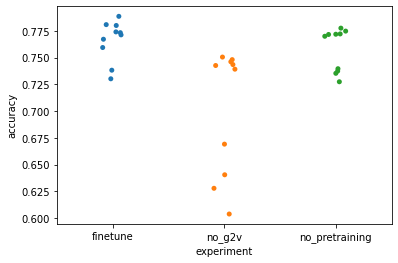

In [67]:
sns.stripplot(data=res, x="experiment", y="accuracy")

### results on "hard to predict" cells

<AxesSubplot:xlabel='experiment', ylabel='acc_hard'>

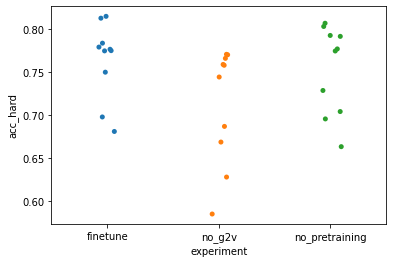

In [68]:
sns.stripplot(data=res, x="experiment", y="acc_hard")

In [90]:
# scBERT reproduced metrics
print("accuracy", res[res.experiment == 'finetune'].acc_hard.mean())
print("95% CI accuracy", calc_95_ci_10samples(res[res.experiment == 'finetune'].acc_hard))
print("f1", res[res.experiment == 'finetune'].f1_hard.mean())
print("95% CI f1", calc_95_ci_10samples(res[res.experiment == 'finetune'].f1_hard))

accuracy 0.7647593582887702
95% CI accuracy 0.029702628612152265
f1 0.7816800762766779
95% CI f1 0.01319169765115049


In [89]:
# scBERT no g2v metrics
print("accuracy", res[res.experiment == 'no_g2v'].acc_hard.mean())
print("95% CI accuracy", calc_95_ci_10samples(res[res.experiment == 'no_g2v'].acc_hard))
print("f1", res[res.experiment == 'no_g2v'].f1_hard.mean())
print("95% CI f1", calc_95_ci_10samples(res[res.experiment == 'no_g2v'].f1_hard))

accuracy 0.7137700534759357
95% CI accuracy 0.04560930436139858
f1 0.7090712417439384
95% CI f1 0.045531364747484204


In [88]:
# scBERT no pretraining metrics
print("accuracy", res[res.experiment == 'no_pretraining'].acc_hard.mean())
print("95% CI accuracy", calc_95_ci_10samples(res[res.experiment == 'no_pretraining'].acc_hard))
print("f1", res[res.experiment == 'no_pretraining'].f1_hard.mean())
print("95% CI f1", calc_95_ci_10samples(res[res.experiment == 'no_pretraining'].f1_hard))

accuracy 0.7537967914438503
95% CI accuracy 0.03486210114378854
f1 0.7722006588576715
95% CI f1 0.015689108962724744


In [91]:
# t-tests
print("t-test for difference in accuracy between finetune and no_g2v")
print(scipy.stats.ttest_ind(res[res.experiment == 'finetune'].acc_hard, res[res.experiment == 'no_g2v'].acc_hard))

print("t-test for difference in f1 between finetune and no_g2v")
print(scipy.stats.ttest_ind(res[res.experiment == 'finetune'].f1_hard, res[res.experiment == 'no_g2v'].f1_hard))

print("\n")

print("t-test for difference in accuracy between finetune and no_pretraining")
print(scipy.stats.ttest_ind(res[res.experiment == 'finetune'].acc_hard, res[res.experiment == 'no_pretraining'].acc_hard))

print("t-test for difference in f1 between finetune and no_pretraining")
print(scipy.stats.ttest_ind(res[res.experiment == 'finetune'].f1_hard, res[res.experiment == 'no_pretraining'].f1_hard))

t-test for difference in accuracy between finetune and no_g2v
Ttest_indResult(statistic=2.010328735354663, pvalue=0.059624286138472676)
t-test for difference in f1 between finetune and no_g2v
Ttest_indResult(statistic=3.2869235477372825, pvalue=0.004097870729776195)


t-test for difference in accuracy between finetune and no_pretraining
Ttest_indResult(statistic=0.5136455208473122, pvalue=0.6137473808085099)
t-test for difference in f1 between finetune and no_pretraining
Ttest_indResult(statistic=0.9923925272382635, pvalue=0.33416019300929245)


# sample efficiency ("few-shot") results

In [87]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
torch.cuda.is_available()
world_size = torch.cuda.device_count()

In [3]:
sampleeff_model_paths = glob.glob('ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/*/*best.pth')

In [4]:
sampleeff_model_paths

['ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.5_1/finetune_sampleeff_0.5_1_best.pth',
 'ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.25_2/finetune_sampleeff_0.25_2_best.pth',
 'ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_1.0_0/finetune_sampleeff_1.0_0_best.pth',
 'ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.75_1/finetune_sampleeff_0.75_1_best.pth',
 'ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.5_2/finetune_sampleeff_0.5_2_best.pth',
 'ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.1_0/finetune_sampleeff_0.1_0_best.pth',
 'ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.25_1/finetune_sampleeff_0.25_1_best.pth',
 'ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.75_2/finetune_sampleeff_0.75_2_best.pth',
 'ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.75_0/finetune_sampleeff_0.75_0_best.pth',
 'ckpts/f

In [96]:
#### reweight for class balance
class_weight = torch.tensor([1/x for x in class_num])  #use this simpler weighting
loss_fn = nn.CrossEntropyLoss(weight=class_weight).to(device)
POS_EMBED_USING = True

# load model
sampeff_accs = []
sampeff_f1s = []
sampeff_experiment = []
sampeff_frac = []
sampeff_run = []
for ckpt_path in sampleeff_model_paths:
    exp = ckpt_path.split("/")[2]
    sampeff_experiment.append(exp)
    sampeff_frac.append(exp.split("_")[-2])
    sampeff_run.append(exp.split("_")[-1])
    print("Loading model: {}".format(ckpt_path))
    print("Experiment: {}".format(exp))
    print("Run: {}".format(exp.split("_")[-1]))
    print("Fraction: {}".format(exp.split("_")[-2]))
    model = PerformerLM(
        num_tokens = CLASS,
        dim = 200,
        depth = 6,
        max_seq_len = SEQ_LEN,
        heads = 10,
        local_attn_heads = 0,
        g2v_position_emb = POS_EMBED_USING,
        g2v_file = G2V_FILE,
        pred_continuous = USE_CONTINUOUS,
        sin_emb_wavelength = SIN_EMB_WAVELENGTH,
    )
    model = model.to(device)

    # Load checkpoint
    checkpoint = torch.load(ckpt_path, map_location=device)
    consume_prefix_in_state_dict_if_present(checkpoint['model_state_dict'], "module.")
    #print("Loaded finetuned ckpt...")
    model.to_out = Identity(dropout=0., h_dim=128, out_dim=label_dict.shape[0])
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)    
    cur_epoch = checkpoint['epoch']

    # model eval
    model.eval()
    running_loss = 0.0
    predictions = []
    truths = []
    with torch.no_grad():
        for index, (data_v, labels_v) in enumerate(val_loader):
            index += 1
            data_v, labels_v = data_v.to(device), labels_v.to(device)
            logits = model(data_v)
            loss = loss_fn(logits, labels_v)
            running_loss += loss.item()
            softmax = nn.Softmax(dim=-1)
            final_prob = softmax(logits)
            final = final_prob.argmax(dim=-1)
            #final[np.amax(np.array(final_prob.cpu()), axis=-1) < UNASSIGN_THRES] = -1
            predictions.append(final)
            truths.append(labels_v)
        del data_v, labels_v, logits, final_prob, final
        # gather
        predictions = torch.cat(predictions, dim=0)
        truths = torch.cat(truths, dim=0)
        no_drop = predictions != -1
        predictions = np.array((predictions[no_drop]).cpu())
        truths = np.array((truths[no_drop]).cpu())
        cur_acc = accuracy_score(truths, predictions)
        f1 = f1_score(truths, predictions, average='macro')
        val_loss = running_loss / index
        sampeff_accs.append(cur_acc)
        sampeff_f1s.append(f1)
        print("Val accuracy: {} || Val F1: {}".format(cur_acc, f1))
        print("\n")

Loading model: ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.5_1/finetune_sampleeff_0.5_1_best.pth
Experiment: finetune_sampleeff_0.5_1
Run: 1
Fraction: 0.5
Val accuracy: 0.735354273192111 || Val F1: 0.6299132294645715


Loading model: ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.25_2/finetune_sampleeff_0.25_2_best.pth
Experiment: finetune_sampleeff_0.25_2
Run: 2
Fraction: 0.25
Val accuracy: 0.6778670562454346 || Val F1: 0.55810039454442


Loading model: ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_1.0_0/finetune_sampleeff_1.0_0_best.pth
Experiment: finetune_sampleeff_1.0_0
Run: 0
Fraction: 1.0
Val accuracy: 0.7892622352081812 || Val F1: 0.7046072236415316


Loading model: ckpts/finetune-sampleeff-2023-Aug-31-23:37:02/finetune_sampleeff_0.75_1/finetune_sampleeff_0.75_1_best.pth
Experiment: finetune_sampleeff_0.75_1
Run: 1
Fraction: 0.75
Val accuracy: 0.756245434623813 || Val F1: 0.6650647201377757


Loading model: ckpts/fin

In [98]:
res_df = pd.DataFrame({'experiment':sampeff_experiment, 'accuracy':sampeff_accs, 'f1':sampeff_f1s,
             'frac':sampeff_frac, 'run':sampeff_run})
res_df.to_csv("sampleeff_metrics.csv")

In [43]:
res_df = pd.read_csv("sampleeff_metrics.csv")

In [44]:
res_df.frac = res_df.frac.astype("float")

In [45]:
res_lr = pd.read_csv("sampleeff_LR_metrics.csv")
res_lr.frac_training_data = res_lr.frac_training_data.astype("float")

<AxesSubplot:xlabel='frac', ylabel='accuracy'>

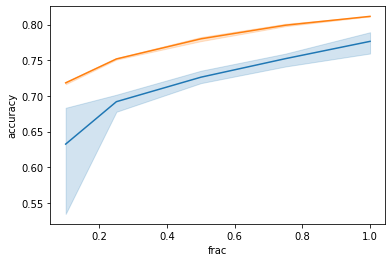

In [122]:
import seaborn as sns
sns.lineplot(data=res_df, x="frac", y="accuracy")
sns.lineplot(data=res_lr, x="frac_training_data", y="test_acc")

In [46]:
res_df['model'] = "scBERT (reproduced)"
res_lr['model'] = "Logistic Regression"

In [47]:
res_df = res_df.rename(columns={'frac':'fraction training data'})
res_lr = res_lr.rename(columns={'frac_training_data':'fraction training data', 'test_acc':'accuracy', 'test_f1':'f1'})

In [48]:
all_res = pd.concat([res_df, res_lr], ignore_index=True)

In [49]:
def jitter(values):
    return values + np.random.normal(0,0.01,values.shape)

all_res['jit_x'] = jitter(all_res['fraction training data'])

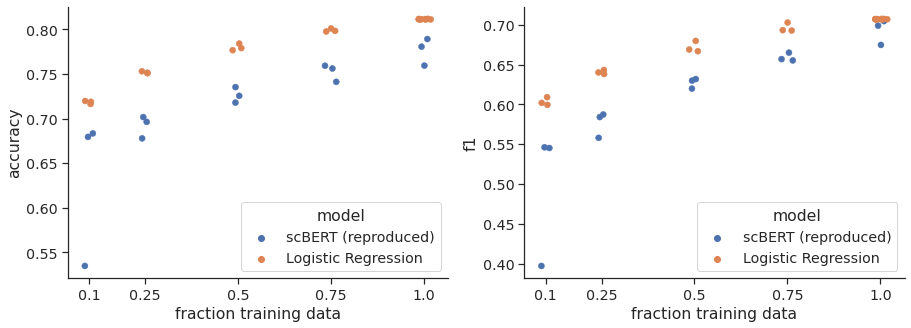

In [48]:
import seaborn as sns
sns.set(font_scale=1.3, style="ticks")
fig, axes = plt.subplots(1,2, figsize=[15,5])
sns.scatterplot(data=all_res, x="jit_x", y="accuracy", hue="model", ax=axes[0], edgecolor = None)#, alpha=0.75)
sns.scatterplot(data=all_res, x="jit_x", y="f1", hue="model", ax=axes[1], edgecolor = None)#, alpha=0.75)
sns.despine()
axes[0].set_xlabel("fraction training data")
axes[1].set_xlabel("fraction training data")
plt.setp(axes, xticks=[0.1, 0.25, 0.5, 0.75, 1.0], xticklabels = [0.1, 0.25, 0.5, 0.75, 1.0]);

## add significance to plots

In [50]:
# calculate significance

pvals = []
p_xpos = []
subplot_ind = []

for f in [0.1, 0.25, 0.5, 0.75]:
    print(f"t-test for difference in accuracy with frac {f}")
    p=scipy.stats.ttest_ind(all_res[(all_res['fraction training data']==f) & (all_res.model=="scBERT (reproduced)")].accuracy, 
                                all_res[(all_res['fraction training data']==f) & (all_res.model=="Logistic Regression")].accuracy)[1]
    print(p)
    pvals.append(p)
    p_xpos.append(f)
    subplot_ind.append(0)

print("\n")
for f in [0.1, 0.25, 0.5, 0.75]:
    print(f"t-test for difference in f1 with frac {f}")
    p = scipy.stats.ttest_ind(all_res[(all_res['fraction training data']==f) & (all_res.model=="scBERT (reproduced)")].f1, 
                                all_res[(all_res['fraction training data']==f) & (all_res.model=="Logistic Regression")].f1)[1]
    print(p)
    pvals.append(p)
    p_xpos.append(f)
    subplot_ind.append(1)    


t-test for difference in accuracy with frac 0.1
0.15426898790314383
t-test for difference in accuracy with frac 0.25
0.0011816016043699317
t-test for difference in accuracy with frac 0.5
0.0006112935825696751
t-test for difference in accuracy with frac 0.75
0.0011747708980759718


t-test for difference in f1 with frac 0.1
0.0965481500809156
t-test for difference in f1 with frac 0.25
0.002413144748773544
t-test for difference in f1 with frac 0.5
0.0012078988881343968
t-test for difference in f1 with frac 0.75
0.0011173331397206843


In [51]:
def convert_pvalue_to_asterisks(pvalue):
    if np.isnan(pvalue):
        return ""
    elif pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

pvals_stars = [convert_pvalue_to_asterisks(p) for p in pvals]

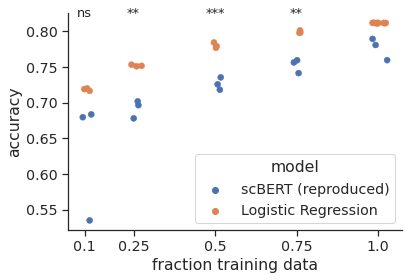

In [55]:
import seaborn as sns
sns.set(font_scale=1.3, style="ticks")
ax = sns.scatterplot(data=all_res, x="jit_x", y="accuracy", hue="model", edgecolor = None)#, alpha=0.75)
sns.despine()
ax.set_xlabel("fraction training data")
ax.set_xticks([0.1, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels([0.1, 0.25, 0.5, 0.75, 1.0])

for idx in np.arange(len(pvals_stars)):
    if subplot_ind[idx]==0:
        height=0.82
    elif subplot_ind[idx]==1:
        height=0.72
        continue
    ax.text(x=p_xpos[idx], y=height, s=pvals_stars[idx], fontsize="small", ha="center")



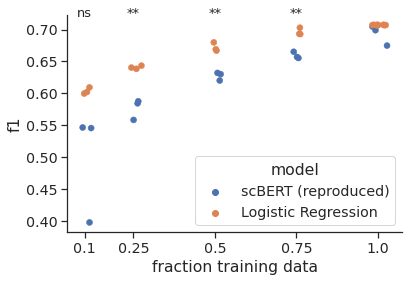

In [57]:
import seaborn as sns
sns.set(font_scale=1.3, style="ticks")
ax=sns.scatterplot(data=all_res, x="jit_x", y="f1", hue="model", edgecolor = None)#, alpha=0.75)
sns.despine()
ax.set_xlabel("fraction training data")
ax.set_xticks([0.1, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels([0.1, 0.25, 0.5, 0.75, 1.0])

for idx in np.arange(len(pvals_stars)):
    if subplot_ind[idx]==0:
        height=0.82
        continue
    elif subplot_ind[idx]==1:
        height=0.72
    ax.text(x=p_xpos[idx], y=height, s=pvals_stars[idx], fontsize="small", ha="center")



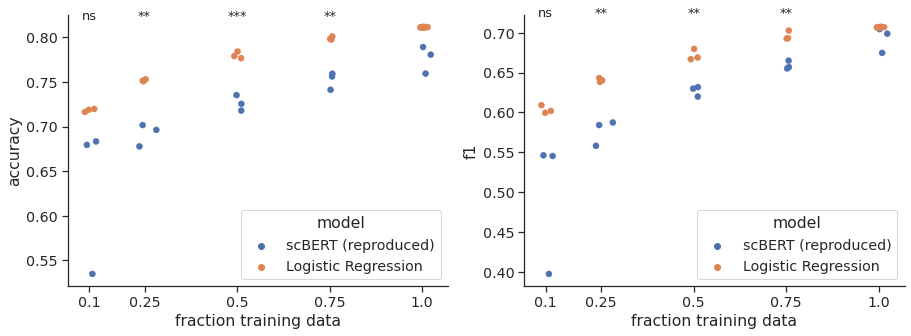

In [34]:
import seaborn as sns
sns.set(font_scale=1.3, style="ticks")
fig, axes = plt.subplots(1,2, figsize=[15,5])
sns.scatterplot(data=all_res, x="jit_x", y="accuracy", hue="model", ax=axes[0], edgecolor = None)#, alpha=0.75)
sns.scatterplot(data=all_res, x="jit_x", y="f1", hue="model", ax=axes[1], edgecolor = None)#, alpha=0.75)
sns.despine()
axes[0].set_xlabel("fraction training data")
axes[1].set_xlabel("fraction training data")
plt.setp(axes, xticks=[0.1, 0.25, 0.5, 0.75, 1.0], xticklabels = [0.1, 0.25, 0.5, 0.75, 1.0]);

for idx in np.arange(len(pvals_stars)):
    if subplot_ind[idx]==0:
        height=0.82
    elif subplot_ind[idx]==1:
        height=0.72
    axes[subplot_ind[idx]].text(x=p_xpos[idx], y=height, s=pvals_stars[idx], fontsize="small", ha="center")

